In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"

/raid/home/bournez_pie/mva_geom/mva_geom_24/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Models for the point clouds ! 

In [2]:
class SirenLayer(nn.Module):
    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        ## Create the layer, and initialize it. You can do it in init_weights

        self.fc1 = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                ## Initialization of first layer type
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
                ## Other initialization
            self.fc1.weight.uniform_(-size, size)

    def forward(self, input):
        ## Logic
        return torch.sin(self.omega_0 * self.fc1(input))


input = torch.randn(2000, 3)
layer = SirenLayer(3, 256, is_first=True)
layer(input)
class SirenNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.0):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.skip = [i in skip for i in range(num_layers)]
        self.omega_0 = omega_0
        layers_list = []
        ## Create layer
        # first layer
        layers_list.append(
            SirenLayer(
                in_features=dim_in,
                out_features=dim_hidden,
                is_first=True,
                omega_0=omega_0,
            )
        )
        for k in range(1, num_layers):
            layers_list.append(
                SirenLayer(
                    in_features=dim_hidden,
                    out_features=dim_hidden,
                    is_first=False,
                    omega_0=omega_0,
                )
            )
        ## Last layer is a simple linear layer. Don't forget to intialize your weights as before!
        self.skip.append(False)
        self.last_layer = nn.Linear(dim_hidden, dim_out, bias=True)
        ## Init last layer
        size = np.sqrt(6 / dim_in) / self.omega_0
        with torch.no_grad():
            self.last_layer.weight.uniform_(-size, size)
        # create the network
        self.layers = nn.ModuleList(layers_list)

    def forward(self, x):
        ## Network logic
        ## You can ignore skip connections at the beginning
        #! The skip is never initialized so we don't know what is exactly this parameters,
        #! we assume it's a list of index where we have to skip the connection

        for index, layer in enumerate(self.layers):
            if self.skip[index]:
                x = x + layer(x)
            else:
                x = layer(x)
        output = self.last_layer(x)
        return output


input = torch.randn(2000, 3, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
net(input) 


tensor([[-0.0382],
        [-0.0825],
        [ 0.0669],
        ...,
        [ 0.0027],
        [-0.0587],
        [-0.2395]], grad_fn=<AddmmBackward0>)

# Create the data

In [3]:
def sample_xt(batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1])
    list = [batch_size, dim_space]
    pts_random = (torch.rand(list, device=device)) * 2 - 1
    time_random = torch.rand(batch_size, device=device)

    return pts_random


## Loss functions 

In [8]:
def project_pc(net,input_pc):
    # apply F (n, fθ ) = n − d × ∇fθ (n, c)/||∇fθ (n, c)||2
    d= net(input_pc)
    grad= gradient(d, input_pc)
    return input_pc - d * grad/ torch.norm(grad, dim=1).view(-1,1)
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
project_pc(net,input_pc).shape

torch.Size([2000, 3])

In [4]:
def alternative_random_choice(
    array: "torch.tensor", size: int, replace: bool = False, shape: int = 0
):
    weights = torch.ones(array.shape[shape])

    idx = torch.multinomial(weights, size, replacement=replace)
    return idx


In [9]:
# data should be 0 on the shape
def loss_data(sdf_pc):
    return torch.mean(sdf_pc**2)  # 

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad


def loss_normalign(grad_pc, sample_nc):
    first_ps = torch.sum(sample_nc * grad_pc, dim=1)
    return ((1 - first_ps) ** 2).mean()
def loss_shape_data(net, pc, normals, batch_size=2000, dim_space=2):
    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=pc, size=batch_size, shape=0)
    sample_pc = pc[idxs]
    sample_pc.requires_grad = True
    sample_nc = normals[idxs]  #! Same idx !

    sdf_pc = net(sample_pc)
    # spatial gradients
    grad_pc = gradient(sdf_pc, sample_pc)[:, 0:2]

    ## compute loss
    loss_pc = 100 * loss_data(sdf_pc) + loss_normalign(grad_pc, sample_nc)
    return loss_pc

In [10]:
import numpy as np
import ot

In [11]:
import numpy as np
import ot
def compute_EMD(net,input_pc ,batch_size,dim_space=2):
    # we compute L(F (Ni, fθ ), Nj ). 
    # We use the EMD loss to compute the distance between the two point clouds

    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=input_pc, size=batch_size, shape=0)
    sample_pc = input_pc[idxs]
    Ni=project_pc(net,sample_pc)
    Nj=input_pc[alternative_random_choice(array=input_pc, size=batch_size, shape=0)]

    # compute the EMD loss
    # Uniform weights for each point (assuming equal weight)
    weights1 = torch.ones(len(Ni)) / len(Ni)
    weights2 = torch.ones(len(Nj))/ len(Nj)
    cost_matrix=ot.dist(Ni, Nj)
    # Compute the Earth Mover's Distance (Optimal Transport)
    emd_value = ot.emd2(weights1, weights2, cost_matrix)
    return emd_value
        
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
compute_EMD(net,input_pc,2000)

tensor(0.0271, grad_fn=<ValFunctionBackward>)

In [12]:
# we compute the second term of the loss
def loss_geometric_consistency(net,input_pc,batch_size=2000,dim_space=2):
    idxs = alternative_random_choice(array=input_pc, size=batch_size, shape=0)
    sample_pc = input_pc[idxs]
    # We compute λ|Ni| * R(E)
    ni_barre=input_pc.shape[0]
    d= net(input_pc)
    nprime=project_pc(net,input_pc=input_pc)
    # compute |fθ (n, c)| − minn′ ∈F (Ni,fθ ) ||n − n′||2)
    # Compute pairwise Euclidean distances in a vectorized way
    dist_matrix = torch.cdist(input_pc, nprime)  # Shape: (N, N)
    
    # Get the minimum distance for each point
    min_distances, _ = torch.min(dist_matrix, dim=1)
    # Apply R(E) and compute sum
    #Compute E
    E = torch.abs(torch.norm(d) - min_distances.unsqueeze(1))  # Broadcasting

    regularization_term = torch.sum(nn.ReLU()(E))

    return 1/input_pc.shape[0] *regularization_term if input_pc.shape[0] > 0 else torch.tensor(0.0)

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency(net,input_pc)

tensor(11.6723, grad_fn=<MulBackward0>)

## compute the eikonal loss

In [13]:
def loss_eikonal_pts(grad_pts):
    ## Get the eikonal loss given spatial gradients
    return torch.mean(torch.abs(torch.norm(grad_pts, dim=1) - 1))
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad
def loss_eikonal(net, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute eikonal loss
    pts_random = sample_xt(batch_size, dim_space)
    pts_random.requires_grad = True

    sdf_random = net(pts_random)

    grad_tot_random = gradient(sdf_random, pts_random)
    grad_spatial = grad_tot_random[:, 0:2]
    return loss_eikonal_pts(grad_spatial)


net = SirenNet(dim_in=2, dim_hidden=256, dim_out=1, num_layers=5).to(device)
loss_eikonal(net, 2000, 2)

tensor(3.1268, grad_fn=<MeanBackward0>)

# Complete loss

In [198]:
def evaluate_loss_cst_vf(
    net,
    pc,
    normals,
    hints_pc,
    gtsdf,
    vf,
    lpc,
    leik,
    lemd,
    lgc,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=1,
    batch_size=2000,
    lambda_gc=1,
    lambda_emd=1,
    dim_space=2
):
    pc.requires_grad = True
    # they are all at time 0 ! 
    # Compute the EMD 
    loss_EMD=compute_EMD(net=net,input_pc=pc,batch_size=batch_size)

    # Compute the geometric consistency loss
    loss_gc=loss_geometric_consistency(net=net,input_pc=pc)

    # compute and store standard losses
    # loss_pc = loss_shape_data(net, pc, normals, batch_size)

    # loss_hint = loss_amb(net, hints_pc, gtsdf, batch_size)

    loss_eik = loss_eikonal(net, batch_size,dim_space=dim_space)

    # loss_lse = loss_lse_eq(net, vf, batch_size)

    # append all the losses
    # lpc.append(float(loss_pc))
    leik.append(float(loss_eik))
    lemd.append(float(loss_EMD))
    lgc.append(float(loss_gc))
    # lh.append(float(loss_hint))
    # llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    loss = (
        # lambda_pc * loss_pc
        lambda_eik * loss_eik+
        lambda_emd * loss_EMD+
        lambda_gc * loss_gc

        # + lambda_hint * loss_hint
        # + lambda_lse * loss_lse
    )

    return loss
pc_input = torch.randn(10000, 3, device=device)
# pc_input.requires_grad = True
normals = torch.randn(10000, 2, device=device)
hints_pc = torch.randn(100000, 3, device=device)
gtsdf = torch.randn(100000, device=device)
vf = torch.randn(2, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=3, num_layers=5).to(device)
lpc = []
leik = []
lh = []
llse = []
lemd=[]
lgc=[]
net = net.to(device)
evaluate_loss_cst_vf(net=net,
                     pc=pc_input,
                     normals=normals,
                     hints_pc=hints_pc,
                     gtsdf=gtsdf,
                     vf=vf,
                     lpc=lpc,
                     leik=leik,
                     lemd=lemd,
                     lgc=lgc,
                     dim_space=3
                     )

tensor(57.4913, grad_fn=<AddBackward0>)

# Run function

In [199]:
def optimize_nise_vf(
    net,
    pc0,
    nc0,
    hints0,
    gtsdf0,
    vf,
    lpc,
    leik,
    lh,
    llse,
    lemd,
    lgc,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=2,
    lambda_gc=1,
    lambda_emd=1,
    batch_size=2000,
    nepochs=100,
    plot_loss=True,
):
    # pc0, nc0, hints0, gtsdf0 are the input data at time  0
    # vf is the velocity field
    # lpc, leik, lh, llse are lists to store the losses
    # lambda_pc, lambda_eik, lambda_hint, lambda_lse are the weights of the losses
    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)

    tinit = time.time()
    pbar = tqdm(total=nepochs, desc="Training")
    for batch in range(nepochs):
        optim.zero_grad()

        loss = evaluate_loss_cst_vf(
            net=net,
            pc=pc0,
            normals=nc0,
            hints_pc=hints0,
            gtsdf=gtsdf0,
            vf=vf,
            lpc=lpc,
            leik=leik,
            lemd=lemd,
            lgc=lgc,
            lambda_pc=lambda_pc,
            lambda_eik=lambda_eik,
            lambda_hint=lambda_hint,
            lambda_lse=lambda_lse,
            batch_size=batch_size,
            lambda_gc=lambda_gc,
            lambda_emd=lambda_emd,
            dim_space=pc0.shape[1]

        )

        loss.backward()
        optim.step()
        if batch % 100 == 99 or batch == 0:
            # print(f"Epoch {batch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)

    tend = time.time()

    print("Optimizing NN took", "{:.2f}".format(tend - tinit), "s.")

# actual data :
For work only 2D canonical shape(?)

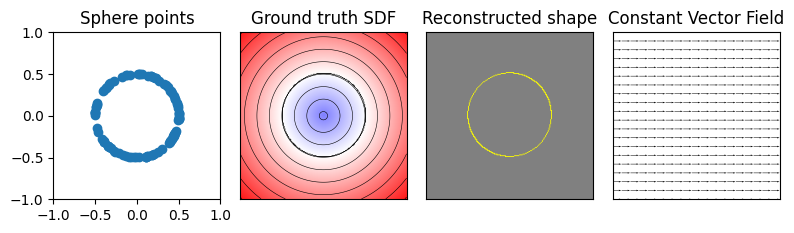

In [200]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 4, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


def get_vector_field_meshgrid(X_value, Y_value):
    # Create a grid of points
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    X, Y = np.meshgrid(x, y)

    # Define the constant vector field (e.g., constant vector [1, 1] everywhere)
    U = np.ones_like(X) * X_value / (10 * max(X_value, Y_value))  # constant x-component
    V = np.ones_like(Y) * Y_value / (10 * max(X_value, Y_value))  # constant y-component
    return X, Y, U, V


X, Y, U, V = get_vector_field_meshgrid(vf[0].item(), vf[1].item())
axs[3].quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1)
axs[3].set_xlim((-1, 1))
axs[3].set_ylim((-1, 1))
axs[3].set_aspect("equal")
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title("Constant Vector Field")
axs[3].grid()
plt.tight_layout()
plt.show()

In [201]:
npl = 128
depth = 3
net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]


In [202]:


pc_t0 = pc0.clone()
pts_hintst0 = pts_hints0.clone()
nepochs = 1000
optimize_nise_vf(
    net=net,
    pc0=pc_t0,
    nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    vf=vf,
    lpc=lpc,
    leik=leik,
    lh=lh,
    llse=llse,
    lemd=lemd,
    lgc=lgc,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=2,
    lambda_gc=1,
    lambda_emd=1,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
)

torch.save(net, "net_vf_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def display_result(f, resolution, filename=None, figsize=(14, 5)):
    """
    displays the values of the function f, evaluated over a regular grid defined between -1 and 1 and of resolution (resolution x resolution)
    """
    fig, plots = plt.subplots(2,2, figsize=figsize)

    for time in range(1):
        i = time//5
        j = time - i*5
        t = 0.1 * time
        coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device = device)]*2, indexing = 'xy')), dim=2).reshape(-1, 2)
        print("coords",coords.shape)
        coords.requires_grad = True
        sdf = f(coords)#.reshape(resolution, resolution)
        print(sdf.shape)
        #reshape sdf
        sdf=sdf.reshape(resolution,resolution)
        numpy_sdf = sdf.detach().cpu().numpy()

        eps = 0.005
        numpy_sdf_max = np.ones(numpy_sdf.shape)-np.maximum(numpy_sdf,np.zeros(numpy_sdf.shape))
        numpy_sdf_max = numpy_sdf_max - np.multiply(numpy_sdf_max, np.multiply(numpy_sdf<=eps, numpy_sdf>=-eps))
        numpy_sdf_min = np.ones(numpy_sdf.shape)-np.maximum(-numpy_sdf,np.zeros(numpy_sdf.shape))
        numpy_sdf_min = numpy_sdf_min - np.multiply(numpy_sdf_min, np.multiply(numpy_sdf<=eps, numpy_sdf>=-eps))
        numpy_sdf_both = np.ones(numpy_sdf.shape)-np.maximum(numpy_sdf,np.zeros(numpy_sdf.shape))-np.maximum(-numpy_sdf,np.zeros(numpy_sdf.shape))
        numpy_sdf_both = numpy_sdf_both - np.multiply(numpy_sdf_both, np.multiply(numpy_sdf<=eps, numpy_sdf>=-eps))

        plots[i,j].axis('off')
        plots[i,j].imshow(np.concatenate([numpy_sdf_min[:,:,np.newaxis],numpy_sdf_both[:,:,np.newaxis],numpy_sdf_max[:,:,np.newaxis]], axis = 2) )
        plots[i,j].contour(numpy_sdf, 10, colors='k', linewidths=.4, linestyles='solid')
    
    if filename==None:
        plt.show()
    else :
        plt.savefig(filename)
        plt.close()


In [190]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def display_result(f, resolution, filename=None, figsize=(14, 5)):
    """
    Displays the values of the function f, evaluated over a regular grid 
    defined between -1 and 1 with a resolution of (resolution x resolution).
    """
    fig, plots = plt.subplots(2, 2, figsize=figsize)

    for time in range(1):
        i = time // 5
        j = time - i * 5
        t = 0.1 * time

        # Create a grid of coordinates
        coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device=device)] * 2, indexing='xy')), dim=2)
        coords = coords.reshape(-1, 2)  # Shape: (resolution*resolution, 2)
        print("coords shape before adding t:", coords.shape)


        # Ensure coordinates require gradients
        coords.requires_grad = True

        # Forward pass through the network
        sdf = f(coords)
        print("sdf shape before reshape:", sdf.shape)

        # Fix reshaping: Remove singleton dimension if present
        sdf = sdf.squeeze(-1).reshape(resolution, resolution)
        numpy_sdf = sdf.detach().cpu().numpy()

        # Processing SDF for visualization
        eps = 0.005
        numpy_sdf_max = 1 - np.maximum(numpy_sdf, np.zeros(numpy_sdf.shape))
        numpy_sdf_max = numpy_sdf_max - np.multiply(numpy_sdf_max, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

        numpy_sdf_min = 1 - np.maximum(-numpy_sdf, np.zeros(numpy_sdf.shape))
        numpy_sdf_min = numpy_sdf_min - np.multiply(numpy_sdf_min, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

        numpy_sdf_both = 1 - np.maximum(numpy_sdf, np.zeros(numpy_sdf.shape)) - np.maximum(-numpy_sdf, np.zeros(numpy_sdf.shape))
        numpy_sdf_both = numpy_sdf_both - np.multiply(numpy_sdf_both, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

        # Displaying the result
        plots[i, j].axis('off')
        plots[i, j].imshow(np.concatenate([numpy_sdf_min[:, :, np.newaxis], 
                                           numpy_sdf_both[:, :, np.newaxis], 
                                           numpy_sdf_max[:, :, np.newaxis]], axis=2))
        plots[i, j].contour(numpy_sdf, 10, colors='k', linewidths=0.4, linestyles='solid')

    # Show or save the figure
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        plt.close()


In [180]:
80000/200

400.0

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 2])


/tmp/ipykernel_824025/3036110033.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2= torch.load("net_vf_128_3.net")


RuntimeError: shape '[200, 200]' is invalid for input of size 80000

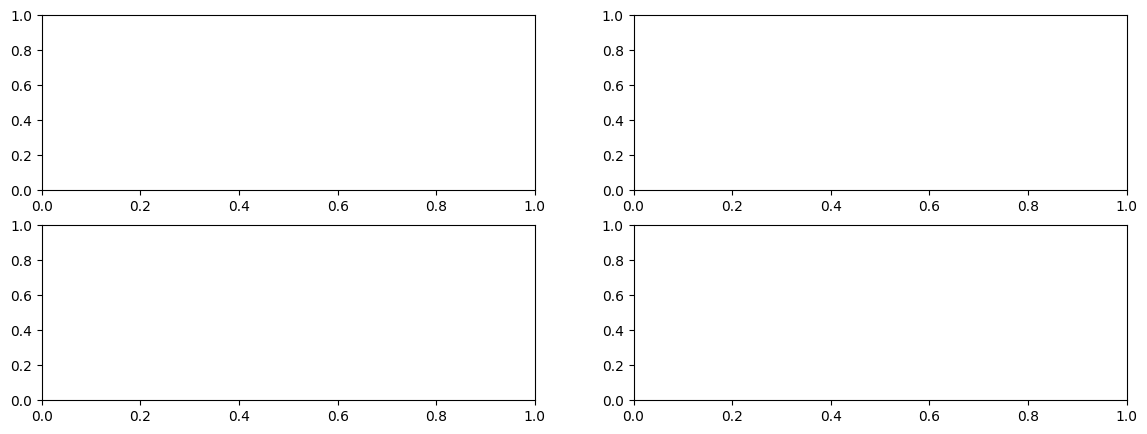

In [191]:
net2= torch.load("net_vf_128_3.net")
display_result(net2, resolution=200, figsize=(14, 5))